In [1]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
import seaborn as sns
from mplsoccer import VerticalPitch,FontManager,add_image,PyPizza
from matplotlib.colors import LinearSegmentedColormap
from matplotlib import colors
from urllib.request import urlopen
from PIL import Image
from matplotlib.patches import Circle, Rectangle, Arc
from highlight_text import fig_text

In [2]:
spaceMono_bold = 'https://github.com/googlefonts/spacemono/blob/main/fonts/SpaceMono-BoldItalic.ttf?raw=true'

from mplsoccer import FontManager
from matplotlib.colors import LinearSegmentedColormap

monoBFont = FontManager(spaceMono_bold)

In [3]:
comps = ["liga"]
season = "2122"
df1 = []
df2 = []
for comp in comps:
    df_def = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/defense.csv")
    df_gs = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/gca.csv")
    df_mis = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/misc.csv")
    df_pass = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/passing.csv")
    df_ptype = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/passing_types.csv")
    df_pos = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/possession.csv")
    df_shot = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/shooting.csv")
    df_stan = pd.read_csv(f"/work/assets/fbref/leagueStats/{comp}/{season}/standard.csv")
    df = pd.concat([df_def, 
                    df_gs, df_mis, 
                    df_pass, 
                    df_ptype, df_pos, 
                    df_shot, 
                    df_stan], axis=1)
    df = df.loc[:,~df.columns.duplicated()]
#     df = df.dropna()
    if comp == comps[0]:
        df1 = df
    elif comp == comps[1]:
        df2 = df
#     if season == seasons[0]:
#         df2021 = df
#     elif season == seasons[1]:
#         df2122 = df


In [15]:
df_stan.columns

Index(['Unnamed: 0', 'Player', 'Nation', 'Pos', 'Squad', 'Age', 'Born',
       'MP_Playing Time', 'Starts_Playing Time', 'Min_Playing Time',
       '90s_Playing Time', 'Gls_Performance', 'Ast_Performance',
       'G-PK_Performance', 'PK_Performance', 'PKatt_Performance',
       'CrdY_Performance', 'CrdR_Performance', 'Gls_Per 90 Minutes',
       'Ast_Per 90 Minutes', 'G+A_Per 90 Minutes', 'G-PK_Per 90 Minutes',
       'G+A-PK_Per 90 Minutes', 'xG_Expected', 'npxG_Expected', 'xA_Expected',
       'npxG+xA_Expected', 'xG_Per 90 Minutes', 'xA_Per 90 Minutes',
       'xG+xA_Per 90 Minutes', 'npxG_Per 90 Minutes',
       'npxG+xA_Per 90 Minutes'],
      dtype='object')

In [16]:
def setup(df,category):
    
    if category=="att":
        df.loc[:, ['Cmp_Total', 'Att_Total', 'Cmp%_Total', 'TotDist_Total',
                   'PrgDist_Total', 'Cmp_Short', 'Att_Short', 'Cmp%_Short', 'Cmp_Medium',
                   'Att_Medium', 'Cmp%_Medium', 'Cmp_Long', 'Att_Long', 'Cmp%_Long', 'Ast',
                   'xA', 'A-xA', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog',
                   'Prog_Carries', 'Succ%_Dribbles', 'GCA_GCA', 'SCA_SCA', 
                   'npxG_Expected', 'xA_Expected']] = \
            df.loc[:, ['Cmp_Total', 'Att_Total', 'Cmp%_Total', 'TotDist_Total',
                       'PrgDist_Total', 'Cmp_Short', 'Att_Short', 'Cmp%_Short', 'Cmp_Medium',
                       'Att_Medium', 'Cmp%_Medium', 'Cmp_Long', 'Att_Long', 'Cmp%_Long', 'Ast',
                       'xA', 'A-xA', 'KP', '1/3', 'PPA', 'CrsPA', 'Prog',
                       'Prog_Carries', 'Succ%_Dribbles', 'GCA_GCA', 'SCA_SCA', 
                       'npxG_Expected', 'xA_Expected']].apply(lambda x:x/df["90s"])
        
        df["Past_Vs Dribbles"] = 100 - df["Past_Vs Dribbles"]
        df["Tkl_Win %"] = (df['TklW_Tackles'] / df['Tkl_Tackles'])*100
        df['PKcon_Performance'] = 10 - df['PKcon_Performance']
        df["Aerial Duels"] = df["Won_Aerial Duels"] + df["Lost_Aerial Duels"]
        
    if category=="def":
        df.loc[:, ['Tkl_Tackles',"TklW_Tackles",'Def 3rd_Tackles', 'Mid 3rd_Tackles','Att 3rd_Tackles', 'Att_Vs Dribbles',
                   'Int','Blocks_Blocks','Fls_Performance', "Won_Aerial Duels", "Lost_Aerial Duels",
                   "Press_Pressures","Succ_Pressures","Recov_Performance",
                   'Def 3rd_Pressures','Mid 3rd_Pressures', 'Att 3rd_Pressures','Sw_Pass Types','Att_Long']] = \
            df.loc[:, ['Tkl_Tackles',"TklW_Tackles",'Def 3rd_Tackles', 'Mid 3rd_Tackles','Att 3rd_Tackles', 'Att_Vs Dribbles',
                       'Int','Blocks_Blocks','Fls_Performance', "Won_Aerial Duels", "Lost_Aerial Duels",
                       "Press_Pressures","Succ_Pressures","Recov_Performance",
                       'Def 3rd_Pressures','Mid 3rd_Pressures', 'Att 3rd_Pressures','Sw_Pass Types','Att_Long']].apply(lambda x:x/df["90s"])
        df["Past_Vs Dribbles"] = 100 - df["Past_Vs Dribbles"]
        df["Tkl_Win %"] = (df['TklW_Tackles'] / df['Tkl_Tackles'])*100
        df['PKcon_Performance'] = 10 - df['PKcon_Performance']
        df["Aerial Duels"] = df["Won_Aerial Duels"] + df["Lost_Aerial Duels"]
    #     df = df[(df["Player"].str.contains("Lenglet"))]
        df = df[df["Pos"].str.contains("DF")]
    #     df = df.drop(columns=["90s","Player"])
    
    if category == "misc":
        df.columns = ['League', 'Season', 'Team', 'Player', 'Nation', 'Pos', 
                      'Age', '90s', 'CrdY', 'CrdR','2CrdY', 'Fls', 'Fld', 
                      'Off', 'Crs', 'Int', 'TklW',
                      'PKwon', 'PKcon', 'OG', 'Recov', 
                      'Aerial Duels Won', 'Aerial Duels Lost', 'Aerial Duels Won %']
        df.drop(index=[0,1],inplace=True)
        df = df.replace(np.inf, np.nan)
        df = df.fillna(0)
        
        df[['Age', '90s', 'CrdY', 'CrdR','2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 
                 'Int', 'TklW', 'PKwon','PKcon', 'OG', 'Recov', 'Aerial Duels Won',
                 'Aerial Duels Lost', 'Aerial Duels Won %']] = df[[ 'Age', '90s', 'CrdY', 'CrdR','2CrdY', 'Fls', 'Fld', 'Off', 'Crs', 
                                                                         'Int', 'TklW', 'PKwon', 'PKcon', 'OG', 'Recov', 'Aerial Duels Won',
                                                                        'Aerial Duels Lost', 'Aerial Duels Won %']].astype(float)
        
        df["Aerial Duels"] = df["Aerial Duels Won"] + df["Aerial Duels Lost"]
        df = df.drop(index=df[df["Player"]=="Squad Total"].index)
       
    
    return df

def mean_norm(df_input):
    return df_input.apply(lambda x: (x-x.mean())/ x.std(), axis=0)


In [5]:
# df1 = setup(df1)
# df2 = setup(df2)
# dfAll = pd.concat([df1,df2])

# seasonが一つ
dfAll = setup(df1)

dfAll = dfAll[dfAll["90s_Playing Time"] > 10]

In [6]:
params = ["Player","xG_Per 90 Minutes","xA_Per 90 Minutes",
          'Tkl_Tackles',"Tkl_Win %", 'Att_Vs Dribbles', 'Tkl%_Vs Dribbles',
          'Int','Blocks_Blocks','Att_Long',"Cmp%_Long",'Sw_Pass Types',
          'PKcon_Performance',
#           'Fls_Performance',
          'Succ_Pressures','%_Pressures',"Recov_Performance",
          "Aerial Duels",'Won%_Aerial Duels']

dfAll = dfAll[params]
dfAll = dfAll.replace(np.inf, np.nan)
dfAll = dfAll.fillna(0)
dfAll.iloc[:,1:] = (mean_norm(dfAll.iloc[:,1:]) * 10) + 50

dfAll["Taijin"] = (dfAll["Att_Vs Dribbles"] + dfAll["Tkl%_Vs Dribbles"]) / 2

dfAll.iloc[:,1:] = dfAll.iloc[:,1:].round(2)

params = ["Player","xG_Per 90 Minutes","xA_Per 90 Minutes",
          'Tkl_Tackles',"Tkl_Win %", "Taijin",
          'Int','Blocks_Blocks','Att_Long',"Cmp%_Long",'Sw_Pass Types',
          'PKcon_Performance',
#           'Fls_Performance',
          'Succ_Pressures','%_Pressures',"Recov_Performance",
          "Aerial Duels",'Won%_Aerial Duels']


dfAll = dfAll[params]

In [8]:
player1 = "Jules Koundé"
values = dfAll[dfAll["Player"].apply(str).str.contains(player1)].values[0]
dfAll[dfAll["Player"].apply(str).str.contains(player1)]

,Player,xG_Per 90 Minutes,xA_Per 90 Minutes,Tkl_Tackles,Tkl_Win %,Taijin,Int,Blocks_Blocks,Att_Long,Cmp%_Long,Sw_Pass Types,PKcon_Performance,Succ_Pressures,%_Pressures,Recov_Performance,Aerial Duels,Won%_Aerial Duels
283,Jules Koundé,49.39,51.5,41.84,48.8,50.58,49.14,41.98,59.07,60.84,59.16,57.15,42.94,59.84,63.72,58.66,57.53


In [38]:
player2 = "Gerard Piqué"
values2 = dfAll[dfAll["Player"].apply(str).str.contains(player2)].values[0]
values2
dfAll[dfAll["Player"].apply(str).str.contains(player2)]

,Player,xG_Per 90 Minutes,xA_Per 90 Minutes,Tkl_Tackles,Tkl_Win %,Taijin,Int,Blocks_Blocks,Att_Long,Cmp%_Long,Sw_Pass Types,PKcon_Performance,Succ_Pressures,%_Pressures,Recov_Performance,Aerial Duels,Won%_Aerial Duels
442,Gerard Piqué,63.64,41.06,37.62,62.6,45.7,43.15,43.63,67.59,64.51,70.41,57.15,45.45,70.92,70.94,66.54,59.93


In [39]:
print(len(params[1:]))
print(len(values[1:]))

16
16


In [40]:
params = ["Player","xG","xA",
          'Attempt\nTackles',"Win %\nTackles",'Taijin',
          'Intercept','Blocks',
          'Attempt\nLong Feed',"Success%\nLong Feed",'Switch Pass','Intelligence\nin Penalty Area',
          'Success\nPressure','Success%\nPressure',"Ball Recovery",
          "Attempt\nAerial Duels",'Win%\nAerial Duels']

In [41]:
text_colors = ["black"] * (len(params)-1)
slice_colors = ["#fb6f92"] * (len(params)-1)
back_colors = ["#171733"] * (len(params)-1)

In [42]:
baker = PyPizza(
    params=params[1:],                  # list of parameters
    background_color="#171733",     # background color
    straight_line_color="#fdc526",  # color for straight lines
    straight_line_limit=70,
    straight_line_lw=1,             # linewidth for straight lines
    last_circle_lw=1,               # linewidth of last circle
    last_circle_color="#fdc526",    # color of last circle
    other_circle_lw=1,              # linewidth for other circles
    inner_circle_size=4             # size of inner circle
)

team: ???? Gerard Piqué


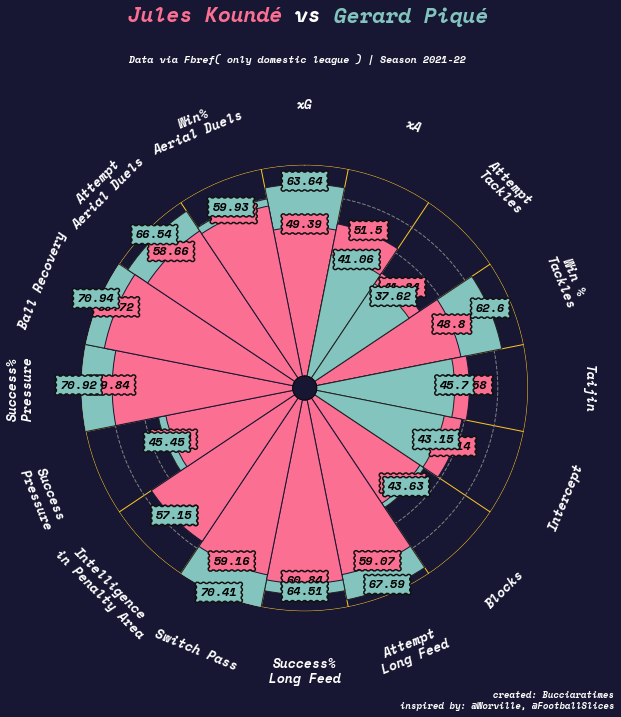

In [44]:
textColor = "#ffffff"
fig_color = "#171733"
fig, ax = baker.make_pizza(
    values[1:],                          # list of values
    compare_values=values2[1:],    # comparison values
    figsize=(8, 8.5),                # adjust figsize according to your need
    color_blank_space=back_colors,        # use same color to fill blank space
    slice_colors=slice_colors,       # color for individual slices
    value_colors=text_colors,        # color for the value-text
    value_bck_colors=slice_colors,   # color for the blank spaces
    blank_alpha=0.5,                 # alpha for blank-space colors
    param_location=90,
    kwargs_slices=dict(
        facecolor=fig_color, edgecolor=fig_color,
        zorder=2, linewidth=1
    ),                   # values to be used when plotting slices
    kwargs_params=dict(
        color="#ffffff", fontsize=13,
        fontproperties=monoBFont.prop,
        va="center", alpha=1
    ),                   # values to be used when adding parameter
    kwargs_values=dict(
        color="#000000", fontsize=12, fontproperties=monoBFont.prop, zorder=3,
        bbox=dict(
            edgecolor="#111111", facecolor="#6CABDD",
            boxstyle="Roundtooth,pad=0.5", lw=1.5)
    ),                    # values to be used when adding parameter-values
    kwargs_compare_values=dict(
        color="#000000", fontsize=12, fontproperties=monoBFont.prop, zorder=3,
        bbox=dict(
            edgecolor="#111111", facecolor="#83c5be", 
                  boxstyle="Roundtooth,pad=0.5", lw=1.5)
    ),
    kwargs_compare=dict(
        facecolor="#83c5be", edgecolor="#222222",
        zorder=2, linewidth=1,
    ),
)
# fig.patches.extend([
#     plt.Rectangle(
#         (0.29, 0.9225), 0.025, 0.021, fill=True, color="#1a78cf",
#         transform=fig.transFigure, figure=fig
#     ),
#     plt.Rectangle(
#         (0.42, 0.9225), 0.025, 0.021, fill=True, color="#ff9300",
#         transform=fig.transFigure, figure=fig
#     ),
#     plt.Rectangle(
#         (0.55, 0.9225), 0.025, 0.021, fill=True, color="#43aa8b",
#         transform=fig.transFigure, figure=fig
#     ),
#     plt.Rectangle(
#         (0.68, 0.9225), 0.025, 0.021, fill=True, color="#d70232",
#         transform=fig.transFigure, figure=fig
#     ),
# ])
# add title
fig_text(s=f"<{player1}> vs <{player2}>",
         x=(ax.get_position().x0+ax.get_position().x1)/5,y=1.095,
         color="#ffffff",
         highlight_colors=["#fb6f92","#83c5be"],
         highlight_weights=["bold"]*2,
         highlight_styles=["italic"]*2,
         fontsize=21,
         fontproperties=monoBFont.prop,fig=fig)

# add subtitle
fig.text(
    0.5, 1.035,
    "Data via Fbref( only domestic league ) | Season 2021-22",
    ha="center", fontproperties=monoBFont.prop, color=textColor
)

# add credits
CREDIT_1 = "created: Bucciaratimes"
CREDIT_2 = "inspired by: @Worville, @FootballSlices"

fig.text(
    1.05, -0.02, f"{CREDIT_1}\n{CREDIT_2}", size=9,
    fontproperties=monoBFont.prop, color="#ffffff",
    ha="right"
)

# add text
# fig.text(  
#     0.32, 0.925, "GK                 DF                 MF               FW", size=14,
#     fontproperties=monoBFont.prop, color=textColor
# )
# URL = "https://github.com/andrewRowlinson/mplsoccer-assets/blob/main/fdj_cropped.png?raw=true"
# wikiのエンブレムをクリックして右下クリックー＞EMbded
# URL = "https://upload.wikimedia.org/wikipedia/en/thumb/e/eb/Manchester_City_FC_badge.svg/1200px-Manchester_City_FC_badge.svg.png"
# URL = "https://upload.wikimedia.org/wikipedia/en/thumb/4/47/FC_Barcelona_%28crest%29.svg/1200px-FC_Barcelona_%28crest%29.svg.png"
# #https://upload.wikimedia.org/wikipedia/en/thumb/a/a7/Paris_Saint-Germain_F.C..svg/1200px-Paris_Saint-Germain_F.C..svg.png
# # URL = "https://upload.wikimedia.org/wikipedia/commons/thumb/1/1b/FC_Bayern_M%C3%BCnchen_logo_%282017%29.svg/1200px-FC_Bayern_M%C3%BCnchen_logo_%282017%29.svg.png"
# cropped = Image.open(urlopen(URL))
# ax_image = add_image(
#     cropped, fig, left=0.4478, bottom=0.4315, width=0.13, height=0.127
# )   # these values might differ when you are plotting

team = input("team: ????")
plt.savefig(f'/work/output/{team}.png', dpi=200, bbox_inches="tight",facecolor="#171733")